In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import functools
from time import time

from astropy.table import Table, vstack, Column

import numpy as np 
import emcee

import scipy.linalg
import scipy.ndimage
import scipy.optimize
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.asap_mass_model import * 
from asap.stellar_mass_function import *

from asap.lts_planefit import lts_planefit

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting
    
from palettable.colorbrewer.sequential import OrRd_3, OrRd_8, Greys_9, PuBu_4
ORG = OrRd_8.mpl_colormap
ORG_2 = OrRd_3.mpl_colormap
BLU = PuBu_4.mpl_colormap
BLK = Greys_9.mpl_colormap

### UM SMDPL data

In [3]:
# Setup environment 
#envir = s16a_path.set_env(version='astro5')
envir = s16a_path.set_env(version='kungpao')

# Folder for new UM model 
um_dir = os.path.join(envir['s16a'], 'um2/um2_new')
um_smdpl_dir = os.path.join(um_dir, 'um_smdpl_small')


um_smdpl_cat = Table.read(os.path.join(um_dir, 'um_smdpl_0.7124_new_vagc_mpeak_11.5.fits'),
                          format='fits')

um_smdpl_cat.sort('halo_hostid')

print(len(um_smdpl_cat))

806306


In [4]:
# Separate the central and satellite
um_cen = um_smdpl_cat[(um_smdpl_cat['upid'] == -1) & (um_smdpl_cat['logmh_vir'] >= 11.3)]
um_sat = um_smdpl_cat[(um_smdpl_cat['upid'] != -1) & (um_smdpl_cat['logmh_vir'] >= 11.3)]

um_cen.sort('halo_hostid')
um_sat.sort('halo_hostid')

print(len(um_cen), len(um_sat))

(384893, 241889)


In [5]:
um_cen.add_column(Column(data=np.log10(um_cen['mtot_galaxy']), name='logms_cen'))
um_sat.add_column(Column(data=np.log10(um_sat['mtot_galaxy']), name='logms_cen'))

In [6]:
um_cen.add_column(Column(data=np.log10(um_cen['sm']), name='logms_ins'))
um_sat.add_column(Column(data=np.log10(um_sat['sm']), name='logms_ins'))

um_cen.add_column(Column(data=np.log10(um_cen['icl']), name='logms_exs'))
um_sat.add_column(Column(data=np.log10(um_sat['icl']), name='logms_exs'))

In [7]:
print(um_smdpl_cat.colnames)

['halo_id', 'upid', 'x', 'y', 'z', 'mvir', 'mpeak', 'sm', 'icl', 'sfr', 'halo_hostid', 'mhalo_host', 'mask_central', 'mtot_galaxy', 'mstar_mhalo', 'logms_gal', 'logms_icl', 'logms_tot', 'logms_halo', 'logmh_vir', 'logmh_peak', 'logmh_host']


### Halo Mass relations

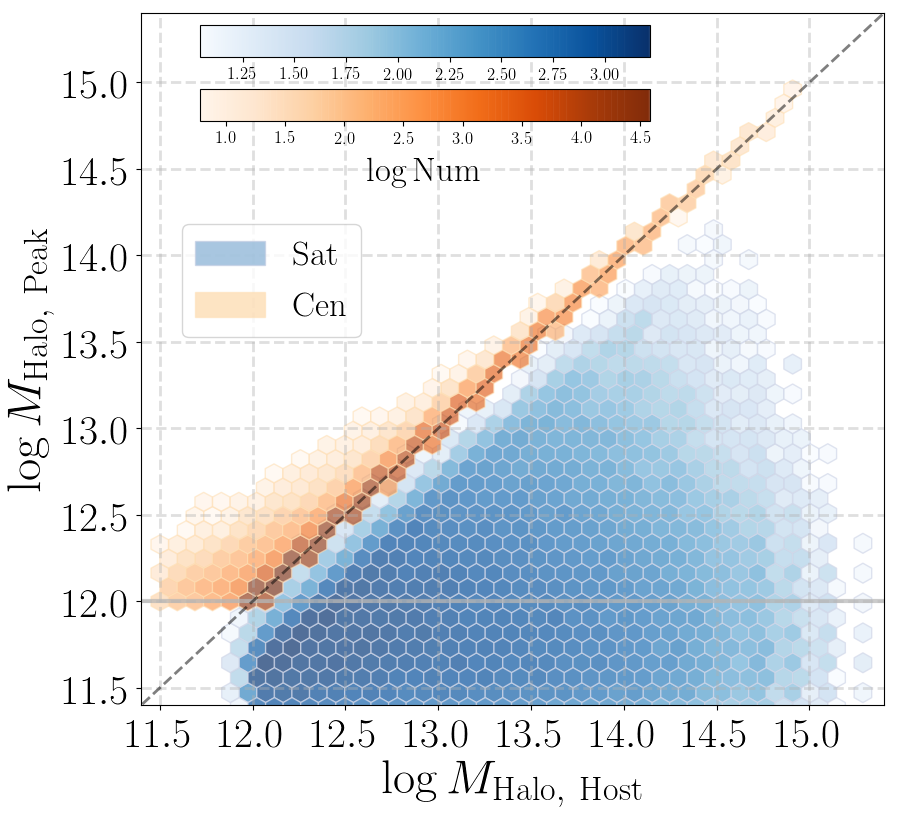

In [348]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex1 = ax1.hexbin(um_sat['logmh_host'], 
                  um_sat['logmh_peak'], gridsize=(40, 21),
                  alpha=0.7, bins='log',
                  mincnt=10, edgecolor=BLU(0.2), cmap='Blues',
                  label=r'$\mathrm{Sat}$')

hex2 = ax1.hexbin(um_cen['logmh_host'], 
                  um_cen['logmh_peak'], gridsize=(40, 20),
                  alpha=0.6, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges',
                  label=r'$\mathrm{Cen}$')

ax1.axhline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, mh_arr, linewidth=2, linestyle='--', alpha=0.5, color='k')

cbar_ax1 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar1 = fig.colorbar(hex1, cax=cbar_ax1, orientation="horizontal")

cbar_ax2 = fig.add_axes([0.22, 0.86, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")

cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar1.solids.set_edgecolor("face")
cbar2.solids.set_edgecolor("face")

legend = ax1.legend(loc='best', fontsize=25, bbox_to_anchor=(0.32, 0.72))
leg = ax1.get_legend()
leg.legendHandles[0].set_facecolor(BLU(0.6))
leg.legendHandles[0].set_edgecolor(BLU(0.3))
leg.legendHandles[1].set_facecolor(ORG(0.6))
leg.legendHandles[1].set_facecolor(ORG(0.3))

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(11.4, 15.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Host}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\mathrm{Halo,\ Peak}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mhost_mpeak.pdf', dpi=100)

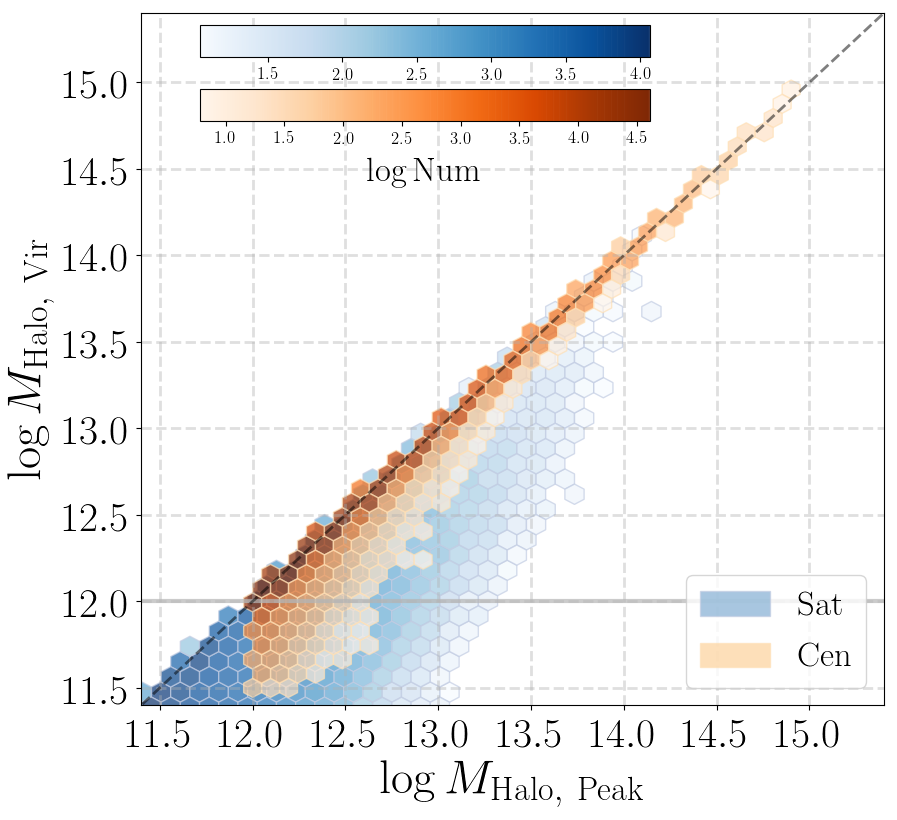

In [349]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex1 = ax1.hexbin(um_sat['logmh_peak'], 
                  um_sat['logmh_vir'], gridsize=(35, 20),
                  alpha=0.7, bins='log',
                  mincnt=10, edgecolor=BLU(0.3), cmap='Blues',
                  label=r'$\mathrm{Sat}$')

hex2 = ax1.hexbin(um_cen['logmh_peak'], 
                  um_cen['logmh_vir'], gridsize=(34, 23),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges',
                  label=r'$\mathrm{Cen}$')

ax1.axhline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, mh_arr, linewidth=2, linestyle='--', alpha=0.5, color='k')

cbar_ax1 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar1 = fig.colorbar(hex1, cax=cbar_ax1, orientation="horizontal")

cbar_ax2 = fig.add_axes([0.22, 0.86, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")

cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar1.solids.set_edgecolor("face")
cbar2.solids.set_edgecolor("face")

legend = ax1.legend(loc=4, fontsize=25)
leg = ax1.get_legend()
leg.legendHandles[0].set_facecolor(BLU(0.6))
leg.legendHandles[0].set_edgecolor(BLU(0.3))
leg.legendHandles[1].set_facecolor(ORG(0.6))
leg.legendHandles[1].set_facecolor(ORG(0.3))

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(11.4, 15.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Peak}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mpeak_mvir.pdf', dpi=100)

### Halo mass - Stellar mass relation

#### Using Mvir - M*,All

In [8]:
# Fit a relation
mask = um_cen['logmh_peak'] > 13.5

smhm_a, smhm_b = np.polyfit(um_cen[mask]['logmh_vir'], um_cen[mask]['logms_halo'], 1)

print("# SMHM : logMs_tot = %6.4f x logMh_vir + %6.4f" % (smhm_a, smhm_b))

# SMHM : logMs_tot = 0.8742 x logMh_vir + -0.0788


In [9]:
logmv_bin = np.linspace(12.0, 15.5, 15)

# For central
idx_logmv_cen = np.digitize(um_cen['logmh_vir'], logmv_bin)
logmv_cen_avg = [np.nanmean(um_cen['logmh_vir'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logms_cen_avg = [np.nanmean(um_cen['logms_halo'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logms_cen_sig = [np.nanstd(um_cen['logms_halo'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]

# For satellites
idx_logmv_sat = np.digitize(um_sat['logmh_vir'], logmv_bin)
logmv_sat_avg = [np.nanmean(um_sat['logmh_vir'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logms_sat_avg = [np.nanmean(um_sat['logms_halo'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logms_sat_sig = [np.nanstd(um_sat['logms_halo'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


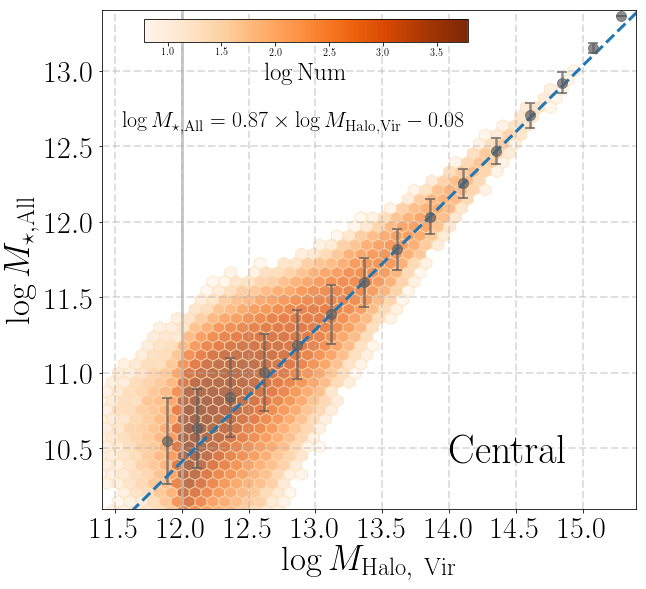

In [41]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_cen['logmh_vir'], 
                  um_cen['logms_halo'], gridsize=(45, 35),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

ax1.errorbar(logmv_cen_avg, logms_cen_avg, yerr=logms_cen_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(11.55, 12.6, r'$\log M_{\star,\mathrm{All}} = 0.87 \times \log M_{\mathrm{Halo,Vir}} - 0.08$', fontsize=22)

ax1.text(14.0, 10.4, r'$\mathrm{Central}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_msall_cen.png', dpi=100)

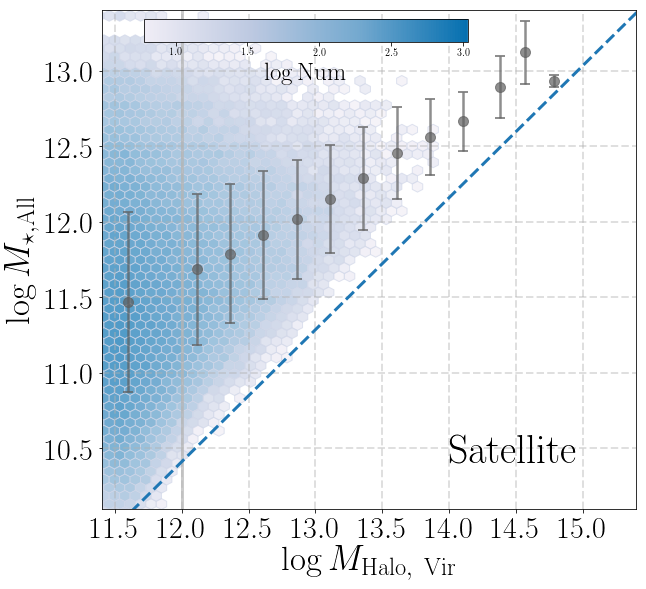

In [40]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_sat['logmh_vir'], 
                  um_sat['logms_halo'], gridsize=(45, 35),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=BLU(0.2), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

ax1.errorbar(logmv_sat_avg, logms_sat_avg, yerr=logms_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.0, 10.4, r'$\mathrm{Satellite}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_msall_sat.png', dpi=100)

#### Using Mpeak - M*,All

In [42]:
# Fit a relation
mask = um_cen['logmh_peak'] > 13.5

smhm_a, smhm_b = np.polyfit(um_cen[mask]['logmh_peak'], um_cen[mask]['logms_halo'], 1)

print("# SMHM : logMs_tot = %6.4f x logMh_peak + %6.4f" % (smhm_a, smhm_b))

# SMHM : logMs_tot = 0.8884 x logMh_peak + -0.2827


In [43]:
logmp_bin = np.linspace(12.0, 15.5, 15)

# For central
idx_logmp_cen = np.digitize(um_cen['logmh_peak'], logmp_bin)
logmp_cen_avg = [np.nanmean(um_cen['logmh_peak'][idx_logmp_cen == k])
                 for k in range(len(logmp_bin))]
logms_cen_avg = [np.nanmean(um_cen['logms_halo'][idx_logmp_cen == k])
                 for k in range(len(logmp_bin))]
logms_cen_sig = [np.nanstd(um_cen['logms_halo'][idx_logmp_cen == k])
                 for k in range(len(logmp_bin))]

# For satellites
idx_logmp_sat = np.digitize(um_sat['logmh_peak'], logmp_bin)
logmp_sat_avg = [np.nanmean(um_sat['logmh_peak'][idx_logmp_sat == k])
                 for k in range(len(logmp_bin))]
logms_sat_avg = [np.nanmean(um_sat['logms_halo'][idx_logmp_sat == k])
                 for k in range(len(logmp_bin))]
logms_sat_sig = [np.nanstd(um_sat['logms_halo'][idx_logmp_sat == k])
                 for k in range(len(logmp_bin))]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


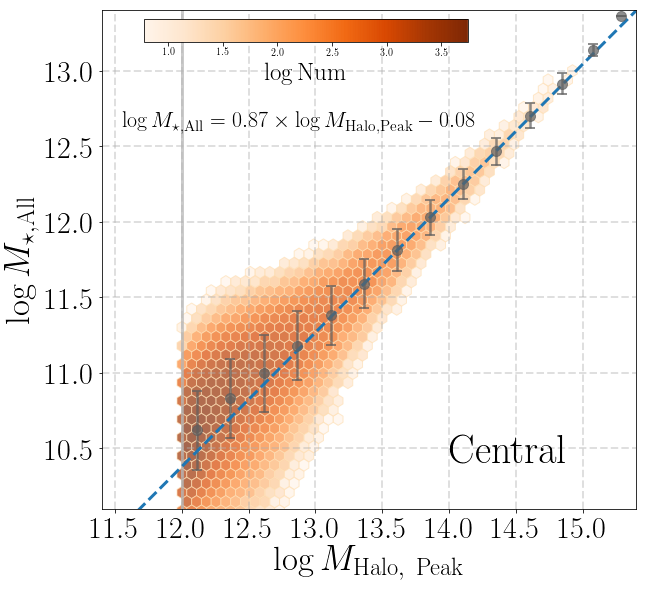

In [46]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_cen['logmh_peak'], 
                  um_cen['logms_halo'], gridsize=(45, 35),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

ax1.errorbar(logmv_cen_avg, logms_cen_avg, yerr=logms_cen_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(11.55, 12.6, r'$\log M_{\star,\mathrm{All}} = 0.87 \times \log M_{\mathrm{Halo,Peak}} - 0.08$', 
         fontsize=22)
ax1.text(14.0, 10.4, r'$\mathrm{Central}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Peak}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mpeak_msall_cen.png', dpi=100)

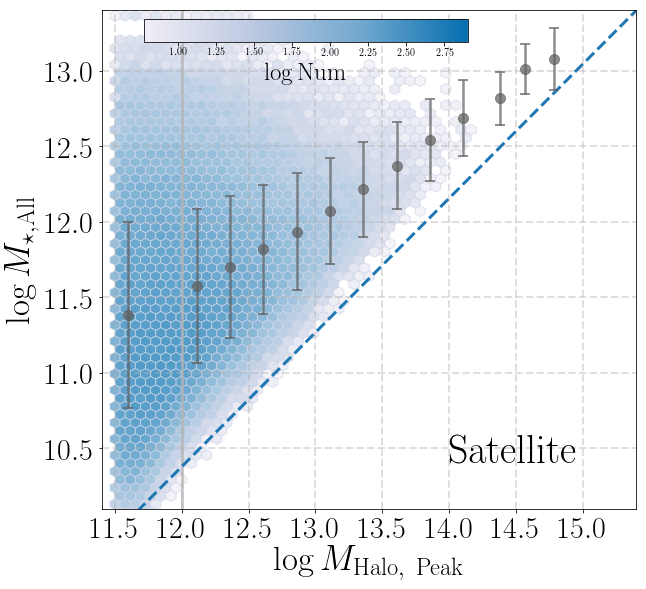

In [47]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_sat['logmh_peak'], 
                  um_sat['logms_halo'], gridsize=(45, 35),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=BLU(0.2), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

ax1.errorbar(logmv_sat_avg, logms_sat_avg, yerr=logms_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.0, 10.4, r'$\mathrm{Satellite}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Peak}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mpeak_msall_sat.png', dpi=100)

#### Using Mhost - M*,All

In [48]:
# Fit a relation
mask = um_cen['logmh_peak'] > 13.5

smhm_a, smhm_b = np.polyfit(um_cen[mask]['logmh_host'], um_cen[mask]['logms_halo'], 1)

print("# SMHM : logMs_tot = %6.4f x logMh_host + %6.4f" % (smhm_a, smhm_b))

# SMHM : logMs_tot = 0.8742 x logMh_host + -0.0788


In [49]:
logmh_bin = np.linspace(12.0, 15.5, 15)

# For central
idx_logmh_cen = np.digitize(um_cen['logmh_host'], logmh_bin)
logmh_cen_avg = [np.nanmean(um_cen['logmh_host'][idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
logms_cen_avg = [np.nanmean(um_cen['logms_halo'][idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
logms_cen_sig = [np.nanstd(um_cen['logms_halo'][idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]

# For satellites
idx_logmh_sat = np.digitize(um_sat['logmh_host'], logmh_bin)
logmh_sat_avg = [np.nanmean(um_sat['logmh_host'][idx_logmh_sat == k])
                 for k in range(len(logmh_bin))]
logms_sat_avg = [np.nanmean(um_sat['logms_halo'][idx_logmh_sat == k])
                 for k in range(len(logmh_bin))]
logms_sat_sig = [np.nanstd(um_sat['logms_halo'][idx_logmh_sat == k])
                 for k in range(len(logmh_bin))]

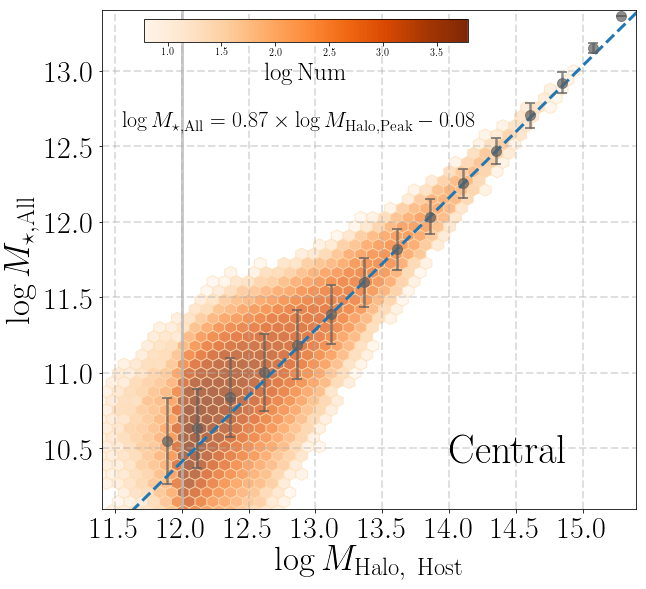

In [50]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_cen['logmh_host'], 
                  um_cen['logms_halo'], gridsize=(45, 35),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

ax1.errorbar(logmv_cen_avg, logms_cen_avg, yerr=logms_cen_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(11.55, 12.6, r'$\log M_{\star,\mathrm{All}} = 0.87 \times \log M_{\mathrm{Halo,Peak}} - 0.08$', 
         fontsize=22)
ax1.text(14.0, 10.4, r'$\mathrm{Central}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Host}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mhost_msall_cen.png', dpi=100)

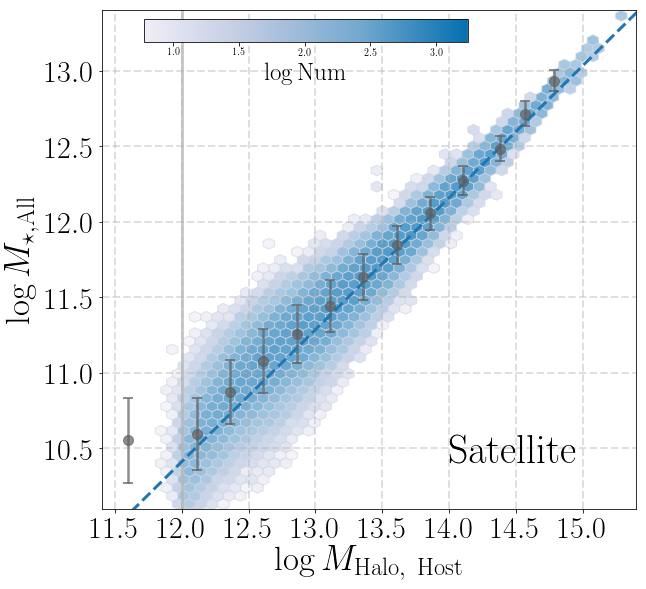

In [51]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_sat['logmh_host'], 
                  um_sat['logms_halo'], gridsize=(45, 35),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=BLU(0.2), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

ax1.errorbar(logmv_sat_avg, logms_sat_avg, yerr=logms_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.0, 10.4, r'$\mathrm{Satellite}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Host}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mhost_msall_sat.png', dpi=100)

#### Using Mvir - M*,Cen

In [55]:
mask = um_cen['logmh_vir'] > 13.8
smhm_c, smhm_d = np.polyfit(um_cen[mask]['logmh_vir'], um_cen[mask]['logms_cen'], 1)

print("# SMHM : logMs_tot = %6.4f x logMh_vir + %6.4f" % (smhm_c, smhm_d))

# SMHM : logMs_tot = 0.7140 x logMh_vir + 1.6259


In [53]:
logmv_bin = np.linspace(12.0, 15.5, 15)

# For central
idx_logmv_cen = np.digitize(um_cen['logmh_vir'], logmv_bin)
logmv_cen_avg = [np.nanmean(um_cen['logmh_vir'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logms_cen_avg = [np.nanmean(um_cen['logms_cen'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logms_cen_sig = [np.nanstd(um_cen['logms_cen'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]

# For satellites
idx_logmv_sat = np.digitize(um_sat['logmh_vir'], logmv_bin)
logmv_sat_avg = [np.nanmean(um_sat['logmh_vir'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logms_sat_avg = [np.nanmean(um_sat['logms_cen'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logms_sat_sig = [np.nanstd(um_sat['logms_cen'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


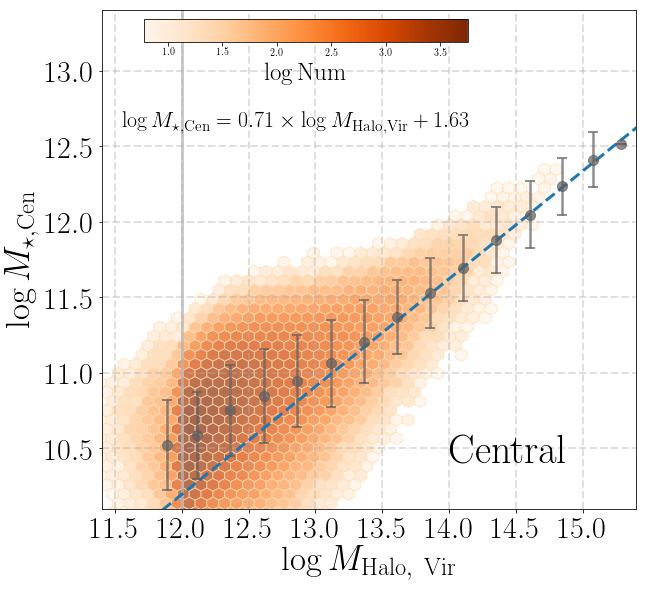

In [54]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_cen['logmh_vir'], 
                  um_cen['logms_cen'], gridsize=(45, 33),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_c * mh_arr + smhm_d, linewidth=3, linestyle='--')

ax1.errorbar(logmv_cen_avg, logms_cen_avg, yerr=logms_cen_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(11.55, 12.6, r'$\log M_{\star,\mathrm{Cen}} = 0.71 \times \log M_{\mathrm{Halo,Vir}} + 1.63$', fontsize=22)

ax1.text(14.0, 10.4, r'$\mathrm{Central}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{Cen}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_mscen_cen.png', dpi=100)

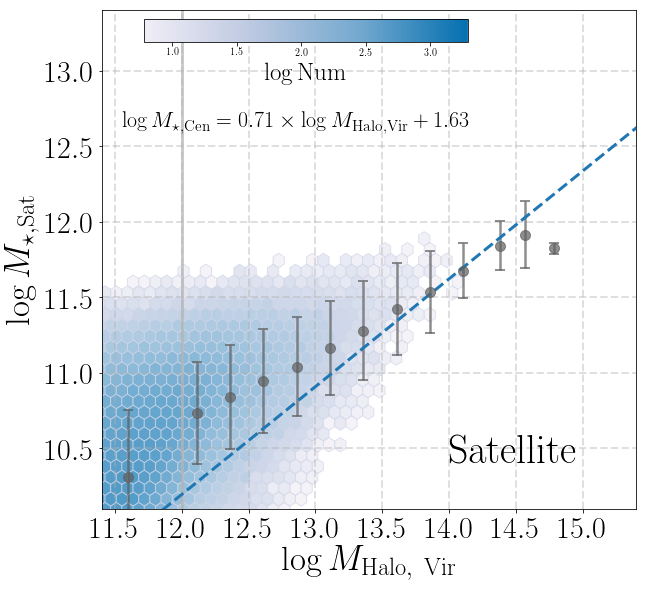

In [62]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_sat['logmh_vir'], 
                  um_sat['logms_cen'], gridsize=(42, 45),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=BLU(0.2), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, smhm_c * mh_arr + smhm_d, linewidth=3, linestyle='--')

ax1.errorbar(logmv_sat_avg, logms_sat_avg, yerr=logms_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.7)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(11.55, 12.6, r'$\log M_{\star,\mathrm{Cen}} = 0.71 \times \log M_{\mathrm{Halo,Vir}} + 1.63$', fontsize=22)

ax1.text(14.0, 10.4, r'$\mathrm{Satellite}$', fontsize=40)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(10.1, 13.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{Sat}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_mscen_sat.png', dpi=100)

In [63]:
# First, estimate the running scatters of logMs_tot
mh_bin = np.linspace(12.1, 15.4, 9)

idx_mhalo = np.digitize(um_cen['logmh_vir'], mh_bin)

mh_avg = [np.nanmean(um_cen['logmh_vir'][idx_mhalo == k]) 
          for k in range(len(mh_bin))]
mh_sig = [np.nanstd(um_cen['logms_halo'][idx_mhalo == k]) 
          for k in range(len(mh_bin))]

sigms_a, sigms_b = np.polyfit(mh_avg, mh_sig, 1)
print("# Mh-sigMs : sigMs = %6.4f x logMh_vir + %6.4f" % (sigms_a, sigms_b))


mh_avg_2 = [np.nanmean(um_cen['logmh_vir'][idx_mhalo == k]) 
            for k in range(len(mh_bin))]
mh_sig_2 = [np.nanstd(um_cen['logms_cen'][idx_mhalo == k]) 
            for k in range(len(mh_bin))]

sigms_c, sigms_d = np.polyfit(mh_avg_2, mh_sig_2, 1)
print("# Mh-sigMs : sigMs = %6.4f x logMh_vir + %6.4f" % (sigms_c, sigms_d))

# Mh-sigMs : sigMs = -0.0653 x logMh_vir + 1.0601
# Mh-sigMs : sigMs = -0.0381 x logMh_vir + 0.7712


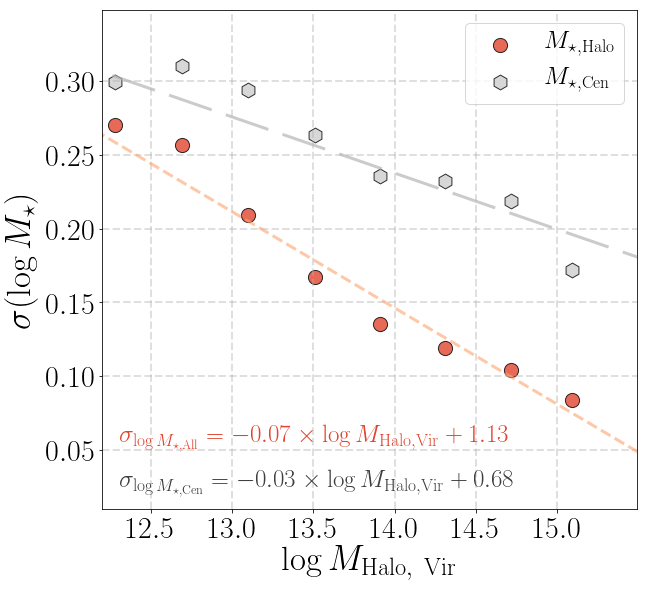

In [64]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
ax1.scatter(mh_avg, mh_sig, marker='o', alpha=0.8, edgecolor='k', s=200, 
            label=r'$M_{\star,\mathrm{Halo}}$', facecolor=ORG(0.8))

ax1.scatter(mh_avg_2, mh_sig_2, marker='h', alpha=0.8, edgecolor='k', s=220, 
            label=r'$M_{\star,\mathrm{Cen}}$', facecolor=BLK(0.3))

mh_arr = np.linspace(11.0, 16.0, 100)
ax1.plot(mh_arr, sigms_a * mh_arr + sigms_b, linewidth=3, linestyle='--', alpha=0.6, color=ORG(0.5),
         label='__no_label__')
ax1.plot(mh_arr, sigms_c * mh_arr + sigms_d, linewidth=3, linestyle='--', alpha=0.7, color=BLK(0.4),
         dashes=(15, 5), label='__no_label__')

ax1.text(12.3, 0.02, r'$\sigma_{\log M_{\star,\mathrm{Cen}}} = -0.03 \times \log M_{\mathrm{Halo,Vir}} + 0.68$', 
         fontsize=25, color=BLK(0.8))
ax1.text(12.3, 0.05, r'$\sigma_{\log M_{\star,\mathrm{All}}} = -0.07 \times \log M_{\mathrm{Halo,Vir}} + 1.13$',
         fontsize=25, color=ORG(0.8))

ax1.set_xlim(12.2, 15.49)
ax1.set_ylim(0.01, 0.348)

legend = ax1.legend(loc=1, fontsize=25)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\sigma(\log M_{\star})$', size=35);

fig.savefig('fig/um_smdpl_mvir_sig_logms.png', dpi=100)

### Halo mass - In situ/ Ex situ fraction trend

#### In situ fraction

In [10]:
logmv_bin = np.linspace(12.0, 15.0, 10)

# For central
idx_logmv_cen = np.digitize(um_cen['logmh_vir'], logmv_bin)
logmv_cen_avg = [np.nanmean(um_cen['logmh_vir'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logmi_cen_avg = [np.nanmean(um_cen['logms_gal'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logmi_cen_sig = [np.nanstd(um_cen['logms_gal'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]

# For satellite
idx_logmv_sat = np.digitize(um_sat['logmh_vir'], logmv_bin)
logmv_sat_avg = [np.nanmean(um_sat['logmh_vir'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logmi_sat_avg = [np.nanmean(um_sat['logms_gal'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logmi_sat_sig = [np.nanstd(um_sat['logms_gal'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]

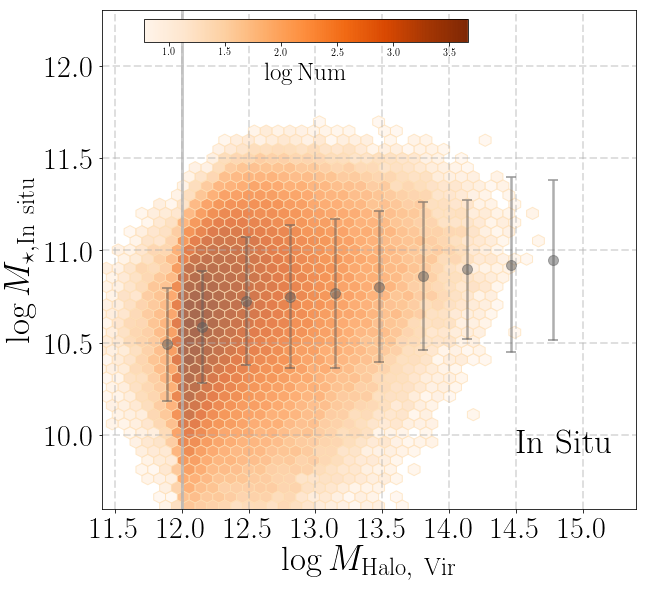

In [70]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    

hex2 = ax1.hexbin(um_cen['logmh_vir'], 
                  um_cen['logms_gal'], gridsize=(45, 70),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

ax1.errorbar(logmv_cen_avg, logmi_cen_avg, yerr=logmi_cen_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.5)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.5, 9.9, r'$\mathrm{In\ Situ}$', fontsize=35)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(9.6, 12.3)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{In\ situ}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_msins_cen.png', dpi=100)

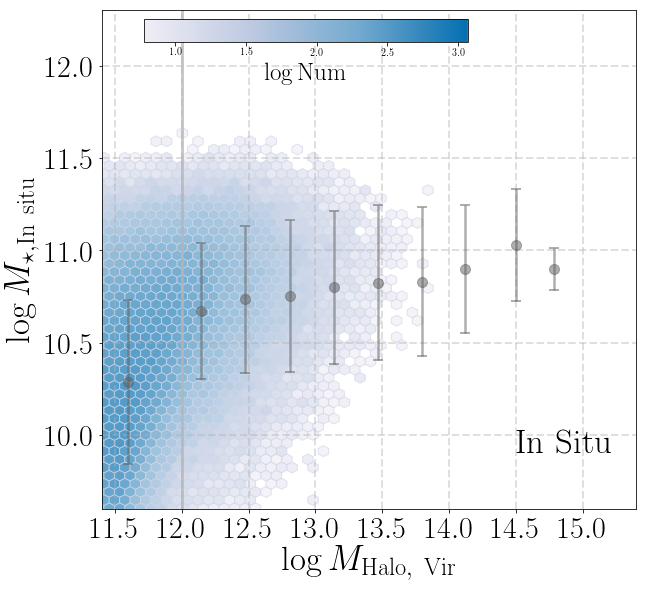

In [71]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    

hex2 = ax1.hexbin(um_sat['logmh_vir'], 
                  um_sat['logms_gal'], gridsize=(45, 70),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=BLU(0.2), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

ax1.errorbar(logmv_sat_avg, logmi_sat_avg, yerr=logmi_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.5)

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.5, 9.9, r'$\mathrm{In\ Situ}$', fontsize=35)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(9.6, 12.3)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{In\ situ}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_msins_sat.png', dpi=100)

#### Ex situ fraction

In [72]:
logmv_bin = np.linspace(12.0, 15.0, 10)

# For central
idx_logmv_cen = np.digitize(um_cen['logmh_vir'], logmv_bin)
logmv_cen_avg = [np.nanmean(um_cen['logmh_vir'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logme_cen_avg = [np.nanmean(um_cen['logms_icl'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]
logme_cen_sig = [np.nanstd(um_cen['logms_icl'][idx_logmv_cen == k])
                 for k in range(len(logmv_bin))]

# For satellite
idx_logmv_sat = np.digitize(um_sat['logmh_vir'], logmv_bin)
logmv_sat_avg = [np.nanmean(um_sat['logmh_vir'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logme_sat_avg = [np.nanmean(um_sat['logms_icl'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]
logme_sat_sig = [np.nanstd(um_sat['logms_icl'][idx_logmv_sat == k])
                 for k in range(len(logmv_bin))]

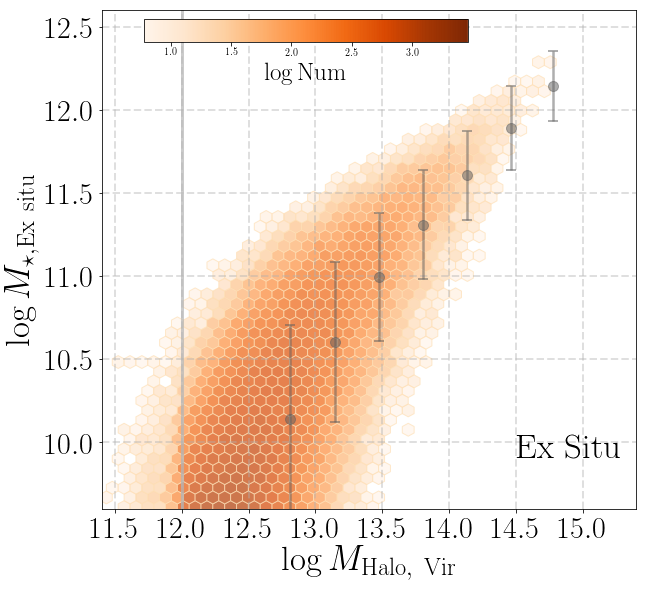

In [74]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_cen['logmh_vir'], 
                  um_cen['logms_icl'], gridsize=(45, 83),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

ax1.errorbar(logmv_cen_avg, logme_cen_avg, yerr=logme_cen_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.5)


cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.5, 9.9, r'$\mathrm{Ex\ Situ}$', fontsize=35)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(9.6, 12.6)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{Ex\ situ}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_mexs_cen.png', dpi=100)

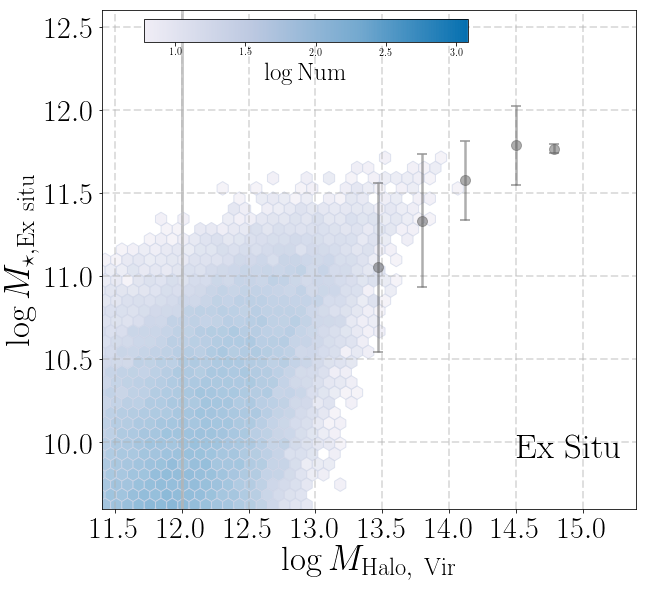

In [76]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_sat['logmh_vir'], 
                  um_sat['logms_icl'], gridsize=(42, 83),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=BLU(0.2), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

ax1.errorbar(logmv_sat_avg, logme_sat_avg, yerr=logme_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.5)


cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.text(14.5, 9.9, r'$\mathrm{Ex\ Situ}$', fontsize=35)

ax1.set_xlim(11.4, 15.4)
ax1.set_ylim(9.6, 12.6)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{Ex\ situ}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mvir_mexs_sat.png', dpi=100)

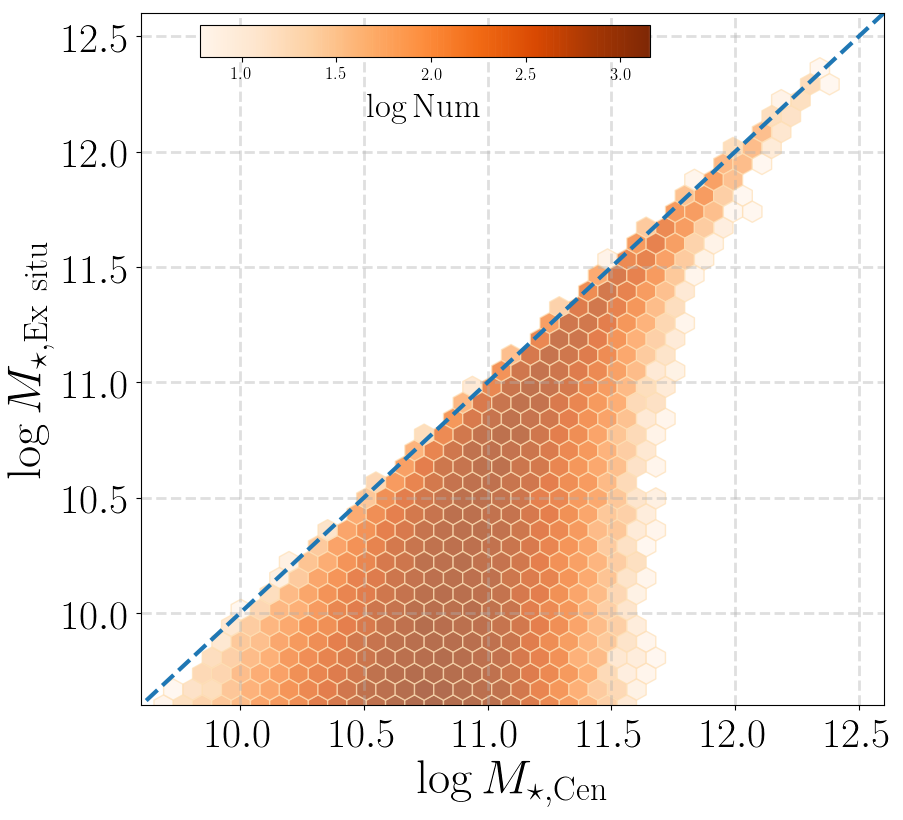

In [358]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
#hex1 = ax1.hexbin(um_sat['logmh_vir'], 
#                  um_sat['logms_halo'], gridsize=(30, 25),
#                  alpha=0.7, bins='log',
#                  mincnt=10, edgecolor=BLU(0.3), cmap='Blues')

hex2 = ax1.hexbin(um_cen['logms_cen'], 
                  um_cen['logms_icl'], gridsize=(52, 70),
                  alpha=0.7, bins='log',
                  mincnt=5, edgecolor=ORG(0.2), cmap='Oranges')

ms_arr = np.linspace(9.0, 13.0, 100)
ax1.plot(ms_arr, ms_arr, linewidth=3, linestyle='--')

#cbar_ax1 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
#cbar1 = fig.colorbar(hex1, cax=cbar_ax1, orientation="horizontal")
#cbar1.solids.set_edgecolor("face")

cbar_ax2 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
#cbar_ax2 = fig.add_axes([0.22, 0.86, 0.5, 0.04])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.set_xlim(9.6, 12.6)
ax1.set_ylim(9.6, 12.6)

_ = ax1.set_xlabel(r'$\log M_{\star, \mathrm{Cen}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star, \mathrm{Ex\ situ}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mcen_mexs.pdf', dpi=100)

### Central to Total fraction

In [11]:
logmh_bin = np.linspace(12.0, 15.0, 10)

frac_cen = um_cen['mtot_galaxy'] / um_cen['mstar_mhalo']
frac_sat = um_sat['mtot_galaxy'] / um_sat['mstar_mhalo']

# For central
idx_logmh_cen = np.digitize(um_cen['logmh_host'], logmh_bin)
logmh_cen_avg = [np.nanmean(um_cen['logmh_host'][idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
fcen_cen_avg = [np.nanmean(frac_cen[idx_logmh_cen == k])
                for k in range(len(logmh_bin))]
fcen_cen_sig = [np.nanstd(frac_cen[idx_logmh_cen == k])
                for k in range(len(logmh_bin))]

# For satellites
idx_logmh_sat = np.digitize(um_sat['logmh_host'], logmh_bin)
logmh_sat_avg = [np.nanmean(um_sat['logmh_host'][idx_logmh_sat == k])
                 for k in range(len(logmh_bin))]
fsat_sat_avg = [np.nanmean(frac_sat[idx_logmh_sat == k])
                for k in range(len(logmh_bin))]
fsat_sat_sig = [np.nanstd(frac_sat[idx_logmh_sat == k])
                for k in range(len(logmh_bin))]

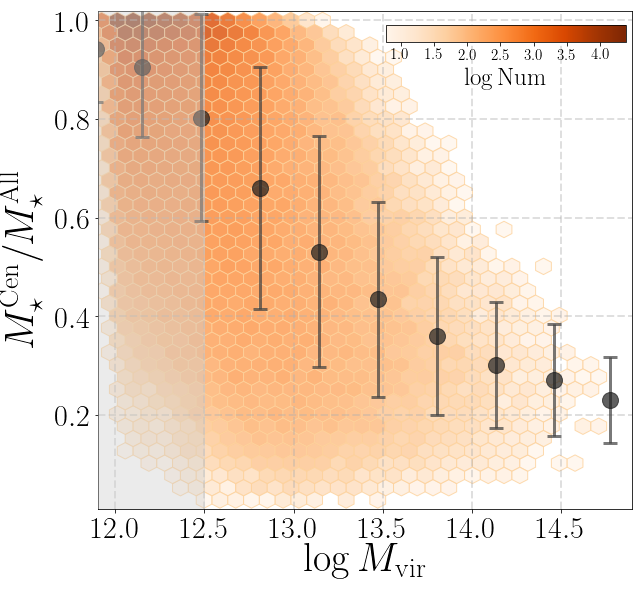

In [23]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.fill_between([11.50, 12.50], [0.0, 0.0], [1.4, 1.4],
                 color=BLK(0.3), edgecolor=BLK(0.6), alpha=0.4, 
                 zorder=20)
    
hex2 = ax1.hexbin(um_cen['logmh_host'], 
                  um_cen['mtot_galaxy'] / um_cen['mstar_mhalo'], 
                  gridsize=(45, 20),
                  alpha=0.8, bins='log',
                  mincnt=5, edgecolor=ORG(0.3), cmap='Oranges')

ax1.errorbar(logmv_cen_avg, fcen_cen_avg, yerr=fcen_cen_sig, fmt='o', 
             ecolor=BLK(0.8), elinewidth=3.0, capsize=7, capthick=3.0,
             color=BLK(0.9), markersize=16, alpha=0.7)


cbar_ax2 = fig.add_axes([0.6, 0.94, 0.37, 0.03])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")
for tick in cbar_ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cbar_ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

ax1.set_xlim(11.9, 14.9)
ax1.set_ylim(0.01, 1.02)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{vir}}$', fontsize=40)
_ = ax1.set_ylabel(r'$M_{\star}^{\mathrm{Cen}}/M_{\star}^{\mathrm{All}}$', 
                   fontsize=40)

fig.savefig('fig/um_smdpl_mhost_frac_mscen_msall_cen.pdf', dpi=110)

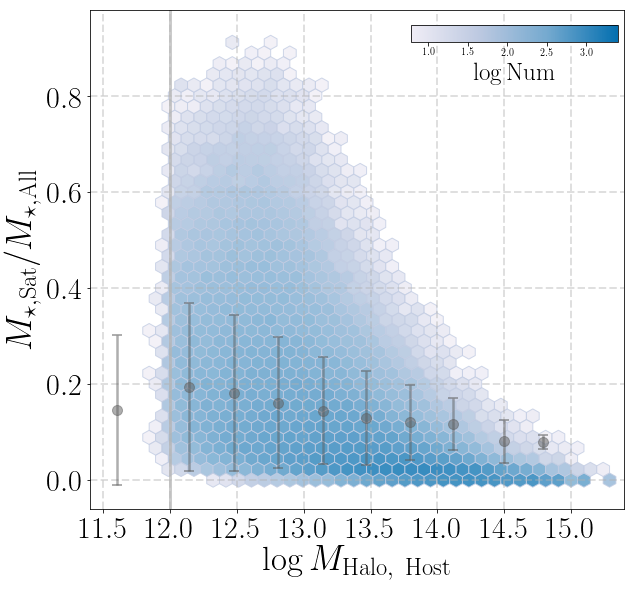

In [83]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
hex2 = ax1.hexbin(um_sat['logmh_host'], 
                  um_sat['mtot_galaxy'] / um_sat['mstar_mhalo'], 
                  gridsize=(40, 22),
                  alpha=0.8, bins='log',
                  mincnt=5, edgecolor=BLU(0.3), cmap=BLU)

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

ax1.errorbar(logmv_sat_avg, fsat_sat_avg, yerr=fsat_sat_sig, fmt='o', 
             ecolor=BLK(0.7), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.7), markersize=10, alpha=0.5)


cbar_ax2 = fig.add_axes([0.65, 0.94, 0.32, 0.03])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.set_xlim(11.4, 15.4)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Host}}$', fontsize=35)
_ = ax1.set_ylabel(r'$M_{\star, \mathrm{Sat}}/M_{\star, \mathrm{All}}$', fontsize=35)

fig.savefig('fig/um_smdpl_mhost_frac_mssat_msall_sat.png', dpi=100)

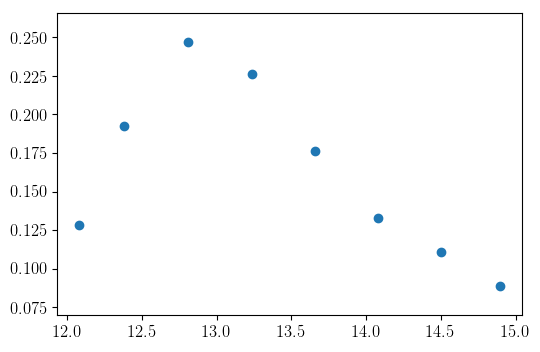

In [237]:
# First, estimate the running scatters of logMs_tot
mh_bin = np.linspace(12.2, 15.2, 8)

idx_mhalo = np.digitize(um_cen['logmh_vir'], mh_bin)

f_cen = um_cen['mtot_galaxy'] / um_cen['mstar_mhalo']

fcen_avg = [np.nanmean(um_cen['logmh_vir'][idx_mhalo == k]) 
            for k in range(len(mh_bin))]
fcen_sig = [np.nanstd(f_cen[idx_mhalo == k]) 
            for k in range(len(mh_bin))]

plt.scatter(fcen_avg, fcen_sig)

### Ex-situ fraction

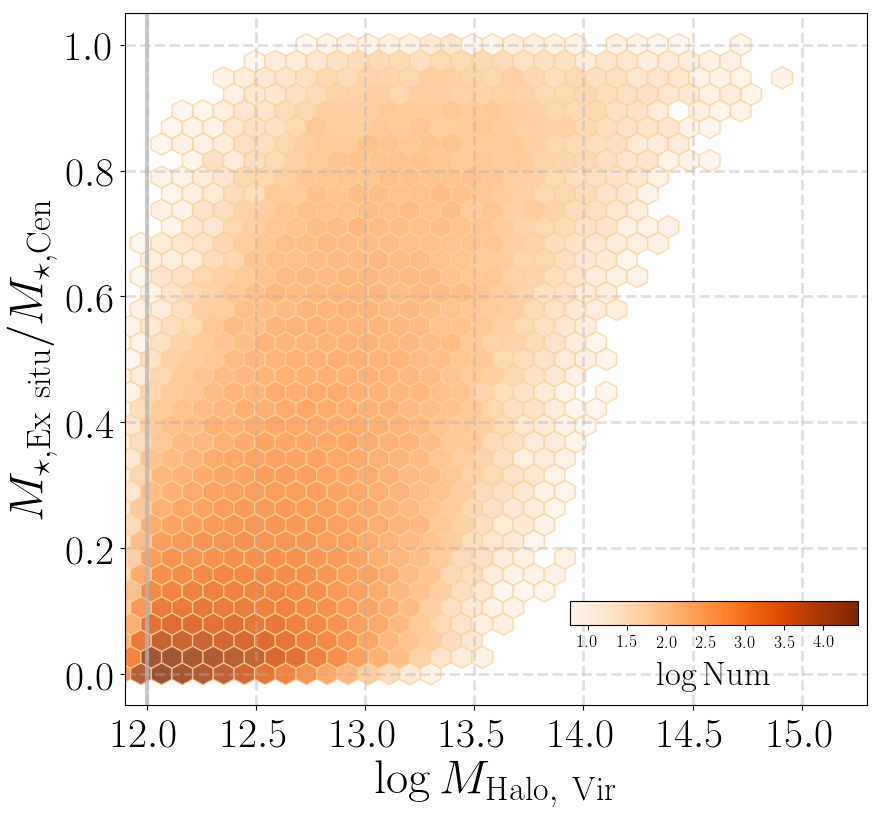

In [377]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
#hex1 = ax1.hexbin(um_sat['logmh_vir'], 
#                  um_sat['logms_halo'], gridsize=(30, 25),
#                  alpha=0.7, bins='log',
#                  mincnt=10, edgecolor=BLU(0.3), cmap='Blues')

hex2 = ax1.hexbin(um_cen['logmh_vir'], 
                  um_cen['icl'] / um_cen['mtot_galaxy'], 
                  gridsize=(40, 19),
                  alpha=0.8, bins='log',
                  mincnt=5, edgecolor=ORG(0.3), cmap='Oranges')

ax1.axvline(12.0, linestyle='-', alpha=0.7, c=BLK(0.4), linewidth=3.0)

cbar_ax2 = fig.add_axes([0.65, 0.23, 0.32, 0.03])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.set_xlim(11.9, 15.3)
#ax1.set_ylim(9.6, 12.3)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$M_{\star, \mathrm{Ex\ situ}}/M_{\star, \mathrm{Cen}}$', fontsize=35)

fig.savefig('um_smdpl_mvir_frac_msexs_mscen.pdf', dpi=100)

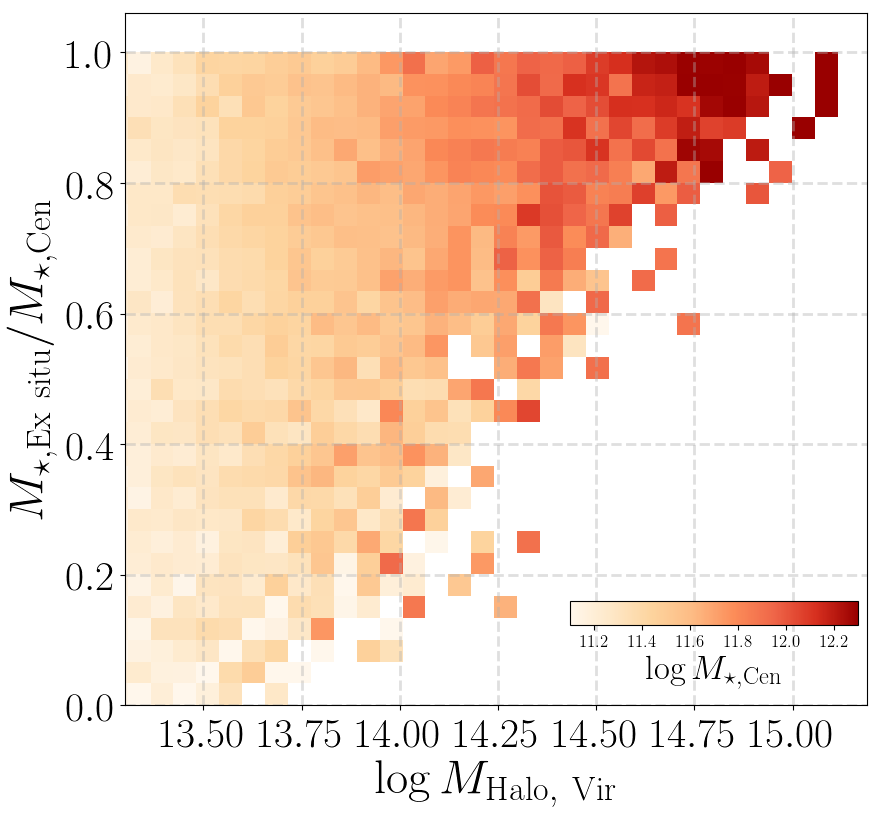

In [378]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
z_stats, x_edges, y_edges = binned_statistic_2d(um_cen['logmh_vir'],
                                                um_cen['icl'] / um_cen['mtot_galaxy'], 
                                                um_cen['logms_cen'], 
                                                np.nanmedian, bins=(65, 30))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=11.1, vmax=12.3,
                aspect='auto', interpolation='nearest', cmap=ORG)


cbar_ax2 = fig.add_axes([0.65, 0.23, 0.32, 0.03])
cbar2 = fig.colorbar(HM, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log M_{\star, \mathrm{Cen}}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.set_xlim(13.3, 15.19)
ax1.set_ylim(0.0, 1.06)

_ = ax1.set_xlabel(r'$\log M_{\mathrm{Halo,\ Vir}}$', fontsize=35)
_ = ax1.set_ylabel(r'$M_{\star, \mathrm{Ex\ situ}}/M_{\star, \mathrm{Cen}}$', fontsize=35)

fig.savefig('um_smdpl_mvir_frac_msexs_mscen_color.pdf', dpi=100)

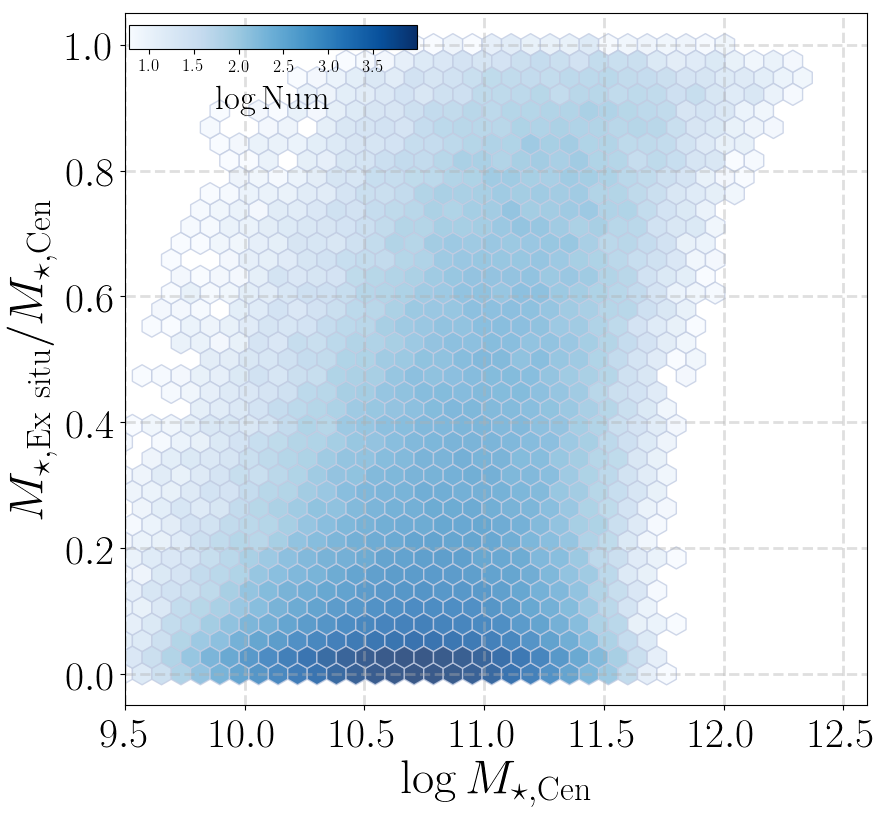

In [380]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
#hex1 = ax1.hexbin(um_sat['logmh_vir'], 
#                  um_sat['logms_halo'], gridsize=(30, 25),
#                  alpha=0.7, bins='log',
#                  mincnt=10, edgecolor=BLU(0.3), cmap='Blues')

hex2 = ax1.hexbin(um_cen['logms_cen'], 
                  um_cen['icl'] / um_cen['mtot_galaxy'], 
                  gridsize=(50, 19),
                  alpha=0.8, bins='log',
                  mincnt=5, edgecolor=BLU(0.3), cmap='Blues')


#mh_arr = np.linspace(11.0, 16.0, 100)
#ax1.plot(mh_arr, smhm_a * mh_arr + smhm_b, linewidth=3, linestyle='--')

#cbar_ax1 = fig.add_axes([0.22, 0.94, 0.5, 0.04])
#cbar1 = fig.colorbar(hex1, cax=cbar_ax1, orientation="horizontal")
#cbar1.solids.set_edgecolor("face")

cbar_ax2 = fig.add_axes([0.16, 0.95, 0.32, 0.03])
cbar2 = fig.colorbar(hex2, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log \mathrm{Num}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.set_xlim(9.5, 12.6)
#ax1.set_ylim(9.6, 12.3)

_ = ax1.set_xlabel(r'$\log M_{\star, \mathrm{Cen}}$', fontsize=35)
_ = ax1.set_ylabel(r'$M_{\star, \mathrm{Ex\ situ}}/M_{\star, \mathrm{Cen}}$', fontsize=35)

fig.savefig('um_smdpl_mcen_frac_msexs_mscen.pdf', dpi=100)

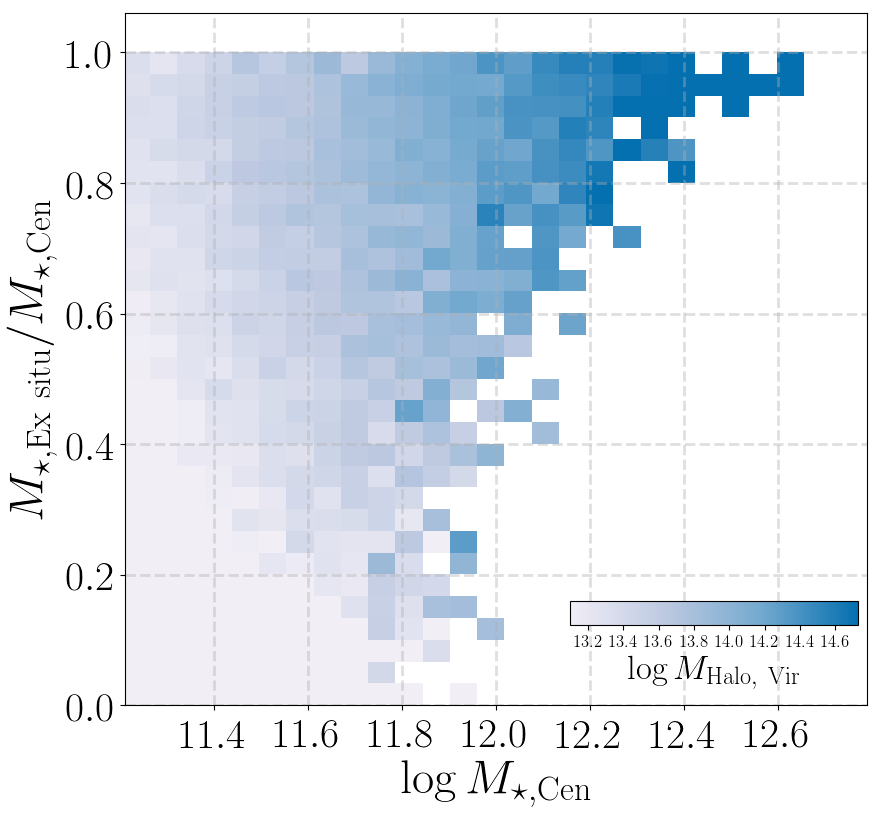

In [381]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.155, right=0.98,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
z_stats, x_edges, y_edges = binned_statistic_2d(um_cen['logms_cen'],
                                                um_cen['icl'] / um_cen['mtot_galaxy'], 
                                                um_cen['logmh_vir'], 
                                                np.nanmedian, bins=(70, 30))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=13.1, vmax=14.73,
                aspect='auto', interpolation='nearest', cmap=BLU)

cbar_ax2 = fig.add_axes([0.65, 0.23, 0.32, 0.03])
cbar2 = fig.colorbar(HM, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label(r'$\log M_\mathrm{Halo,\ Vir}$', fontsize=25)
cbar2.solids.set_edgecolor("face")

ax1.set_xlim(11.21, 12.79)
ax1.set_ylim(0.0, 1.06)

_ = ax1.set_xlabel(r'$\log M_{\star, \mathrm{Cen}}$', fontsize=35)
_ = ax1.set_ylabel(r'$M_{\star, \mathrm{Ex\ situ}}/M_{\star, \mathrm{Cen}}$', fontsize=35)

fig.savefig('um_smdpl_mcen_frac_msexs_mscen_color.pdf', dpi=100)

### Halo Mass function and Stellar mass function

In [364]:
smdpl_vol = np.power(400.0 / 0.7, 3)    # Mpc^2

logmp_cen_bin, logmp_cen_phi, logmp_cen_phi_err = compute_smf(um_cen['logmh_peak'], smdpl_vol, 20, 12.1, 15.5)
logmp_sat_bin, logmp_sat_phi, logmp_sat_phi_err = compute_smf(um_sat['logmh_peak'], smdpl_vol, 20, 12.1, 15.5)

logmh_cen_bin, logmh_cen_phi, logmh_cen_phi_err = compute_smf(um_cen['logmh_vir'], smdpl_vol, 20, 12.1, 15.5)
logmh_sat_bin, logmh_sat_phi, logmh_sat_phi_err = compute_smf(um_sat['logmh_vir'], smdpl_vol, 20, 12.1, 15.5)

logmt_cen_bin, logmt_cen_phi, logmt_cen_phi_err = compute_smf(um_cen['logms_halo'], smdpl_vol, 12, 11.0, 13.9)
logmt_sat_bin, logmt_sat_phi, logmt_sat_phi_err = compute_smf(um_sat['logms_halo'], smdpl_vol, 12, 11.0, 13.9)

logmc_cen_bin, logmc_cen_phi, logmc_cen_phi_err = compute_smf(um_cen['logms_cen'], smdpl_vol, 12, 11.0, 13.5)
logmc_sat_bin, logmc_sat_phi, logmc_sat_phi_err = compute_smf(um_sat['logms_cen'], smdpl_vol, 12, 11.0, 13.5)

logmi_cen_bin, logmi_cen_phi, logmi_cen_phi_err = compute_smf(um_cen['logms_ins'], smdpl_vol, 12, 11.0, 13.5)
logmi_sat_bin, logmi_sat_phi, logmi_sat_phi_err = compute_smf(um_sat['logms_ins'], smdpl_vol, 12, 11.0, 13.5)

logmo_cen_bin, logmo_cen_phi, logmo_cen_phi_err = compute_smf(um_cen['logms_exs'], smdpl_vol, 12, 11.0, 13.5)
logmo_sat_bin, logmo_sat_phi, logmo_sat_phi_err = compute_smf(um_sat['logms_exs'], smdpl_vol, 12, 11.0, 13.5)

In [365]:
smf_dir = '/Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf'

smf_mmax = Table.read(os.path.join(smf_dir, 's16a_wide2_massive_smf_mmax_11.5.fits'))
smf_m10 = Table.read(os.path.join(smf_dir, 's16a_wide2_massive_smf_m10_11.5.fits'))

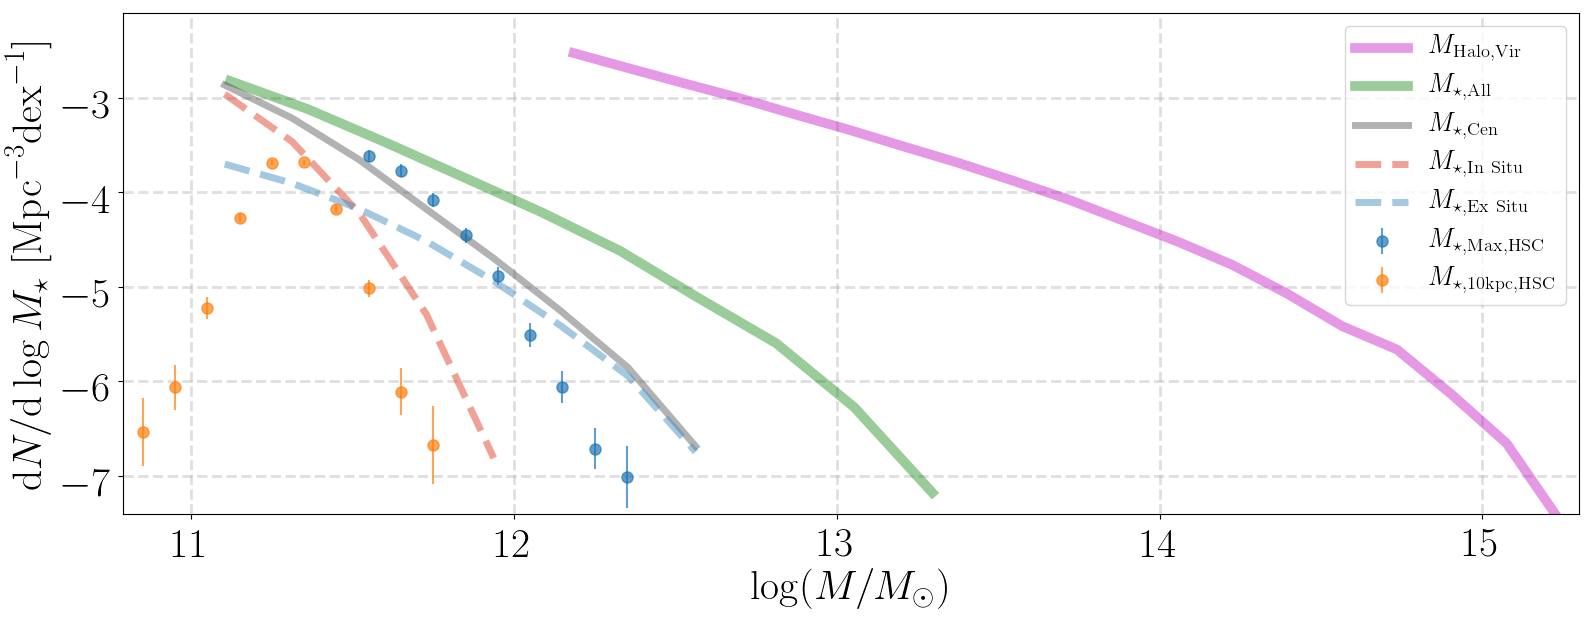

In [373]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(left=0.08, right=0.99,
                    bottom=0.16, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
    
ax1.plot(logmh_cen_bin, np.log10(logmh_cen_phi), linewidth=7, alpha=0.4, c='m', 
         label=r'$M_{\mathrm{Halo,Vir}}$')

ax1.plot(logmt_cen_bin, np.log10(logmt_cen_phi), linewidth=7, alpha=0.4, c='g', 
         label=r'$M_{\star,\mathrm{All}}$')

ax1.plot(logmc_cen_bin, np.log10(logmc_cen_phi), linewidth=5, alpha=0.4, c=BLK(0.8), 
         label=r'$M_{\star,\mathrm{Cen}}$')

ax1.plot(logmi_cen_bin, np.log10(logmi_cen_phi), linewidth=5, linestyle='--', alpha=0.5, c=ORG(0.8), 
         label=r'$M_{\star,\mathrm{In\ Situ}}$')

ax1.plot(logmo_cen_bin, np.log10(logmo_cen_phi), linewidth=5, linestyle='--', alpha=0.5, c=BLU(0.8), 
         label=r'$M_{\star,\mathrm{Ex\ Situ}}$')

ax1.errorbar(smf_mmax['logm_mean'], np.log10(smf_mmax['smf']),
             yerr=(np.log10(smf_mmax['smf_upp']) - np.log10(smf_mmax['smf'])),
             fmt='o', markersize=8, alpha=0.7, label=r'$M_{\star,\mathrm{Max,HSC}}$')

ax1.errorbar(smf_m10['logm_mean'], np.log10(smf_m10['smf']),
             yerr=(np.log10(smf_m10['smf_upp']) - np.log10(smf_m10['smf'])),
             fmt='o', markersize=8, alpha=0.7, label=r'$M_{\star,10\mathrm{kpc,HSC}}$')


ax1.legend(loc='best', fontsize=19)

ax1.set_xlim(10.79, 15.3)
ax1.set_ylim(-7.4, -2.1)

_ = ax1.set_xlabel(r'$\log (M/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=30)

fig.savefig('um_smdpl_mf_smf_6.pdf', dpi=100)